In [1]:
#####Adaptive mechanism from Williams & Noble (2007)#####

import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
##create CTRNN

def sigmoid(x):
    return 1/(1+np.exp(-x))

class CTRNN():

    def __init__(self,size,dt,segmentlen,numsegments):
        self.Size = size                                        # number of neurons in the circuit
        self.States = np.ones(size)                             # state of the neurons
        self.Outputs = np.zeros(size)                           # neuron outputs
        self.PlasticFacilitation = np.zeros(size)               #value of rho for each neuron to use in adaptive mech
        self.dt = dt                                            #size of walking timestep
        self.Segmentlength = segmentlen                         #how many timesteps taken before learning/adaptation opportunity
        self.Numbersegments = numsegments                       #how many segments to divide timeseries into (how many opportunities for learning)
        totalduration = segmentlen * dt * numsegments           #how long in seconds the simulation will run
        self.time = np.arange(0.0,totalduration,dt)             #timeseries values in seconds
        self.ctrnn_record = np.zeros((size,len(self.time)))     #place to store data of the node firing rates over time
        self.input_record = np.zeros(len(self.time))
        self.Stepnum = 0                                        #initialize the step count at 0
        self.Segmentnum = 0                                     #initialize the segment count at 0

    def resetStepcount():
        self.Stepnum = 0
        
    def setInputs(self,inputs): #external input to each neuron
        self.Inputs = inputs
    
    def setWeights(self, weights): #weight of connection for each neuron pair, going from row (i) to column (j)
        self.Weights = weights
        
    def randomizeWeights(self):
        self.Weights = np.random.uniform(-10,10,size=(self.Size,self.Size))

    def setBiases(self, biases): #bias shift for each neuron
        self.Biases =  biases
    
    def randomizeBiases(self):
        self.Biases = np.random.uniform(-10,10,size=(self.Size))

    def setTimeConstants(self, timeconstants): #time constant for each neuron
        self.TimeConstants =  timeconstants
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def randomizeTimeConstants(self):
        self.TimeConstants = np.random.uniform(0.1,5.0,size=(self.Size))
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def setAdaptiveTimeConstants(self, adaptiveWtimeconstant, adaptiveBtimeconstant): #time constants for the adaptation of the weights & biases
        self.invadaptWTimeConst = 1.0/adaptiveWtimeconstant
        self.invadaptBTimeConst = 1.0/adaptiveBtimeconstant
        
    def randomizeAdaptiveTimeConstants(self):
        self.invadaptWTimeConst = 1.0/np.random.uniform(10,50)
        self.invadaptBTimeConst = 1.0/np.random.uniform(10,50)
        
    def setFacilitationFunctionParams(self,pLow,pHigh,pSlope): #the parameters for the plastic facilitation function to determine rho
        self.pLow = pLow
        self.pHigh = pHigh
        self.pSlope = pSlope #always <0
        
    def randomizeFacilitationFunctionParams(self):
        self.pLow = np.random.uniform(.01,.49) #between .01 and .49 initially, although strictly only has to be lower than pHigh
        self.pHigh = np.random.uniform(.51,.99) #between .51 and .99 initially, although strictly only has to be higher than pLow
        self.pSlope = np.random.uniform(-10,0) #always <0

    def initializeState(self, s):
        self.States = s
        self.Outputs = sigmoid(self.States+self.Biases)
        
    def plasticFacilitationCalc(self,speed): #calculate and update the value of rho for each neuron, using the mean firing rate from the preceding segment of runtime
        for i in range(self.Size):
            avg_firingrate = np.mean(self.ctrnn_record[i,self.Segmentlength*self.Segmentnum:self.Segmentlength*(self.Segmentnum+1)])
            if  avg_firingrate < self.pLow:
                self.PlasticFacilitation[i] = self.pSlope*(avg_firingrate - self.pLow )
                #print("low",self.PlasticFacilitation[i])
            elif avg_firingrate > self.pHigh:
                self.PlasticFacilitation[i] = self.pSlope*(avg_firingrate - self.pHigh)
                #print("high",self.PlasticFacilitation[i])
            else:
                self.PlasticFacilitation[i] = (self.pLow-self.pHigh)*np.random.uniform(-1,1)*(2/(sigmoid(30*speed))-1)  #if in range, will still change but proportional to 1/speed
                
    
    def updateBiases(self): #use the value of rho for each neuron to dynamically change biases, scaling the change by 1/speed of walking
        for i in range(self.Size):
            self.Biases[i] += self.dt * self.invadaptBTimeConst * self.PlasticFacilitation[i]
    
    def updateWeights(self): #use the value of rho for each neuron to dynamically change all incoming weights to that neuron, scaling the change by 1/speed of walking
        for j in range(self.Size):
            incomingWeights = self.Weights[:,j]
            incomingWeights += self.dt * self.invadaptWTimeConst * self.PlasticFacilitation[j] * np.absolute(incomingWeights)
            self.Weights[:,j] = incomingWeights
        
    def ctrnnstep(self): #use the value of the weights and outputs to change the state of each neuron
        netinput = self.Inputs + np.dot(self.Weights.T, self.Outputs)
        self.States += self.dt * (self.invTimeConstants*(-self.States+netinput))
        self.Outputs = sigmoid(self.States+self.Biases)
        self.ctrnn_record[:,self.Stepnum] = self.Outputs
        self.input_record[self.Stepnum] = np.mean(self.Inputs)
        self.Stepnum += 1

    def learnstep(self,speed): #a chance for learning/homeostatic mechanism/adaptation using speed feedback from a segment of walking
        self.plasticFacilitationCalc(speed)
        self.Segmentnum += 1
        self.updateBiases()
        self.updateWeights()
        
    def plot(self,iplot):
        for i in range(self.Size):
            lab = "Neuron %d" %i
            plt.plot(self.time,self.ctrnn_record[i],label=lab)
        if iplot:
            plt.plot(self.time,self.input_record,label="Input")
        plt.title("Neural Activity")
        plt.xlabel("Time (s)")
        plt.ylabel("Firing Rate")
        plt.rcParams["figure.figsize"] = (20,3)
        plt.legend()
            

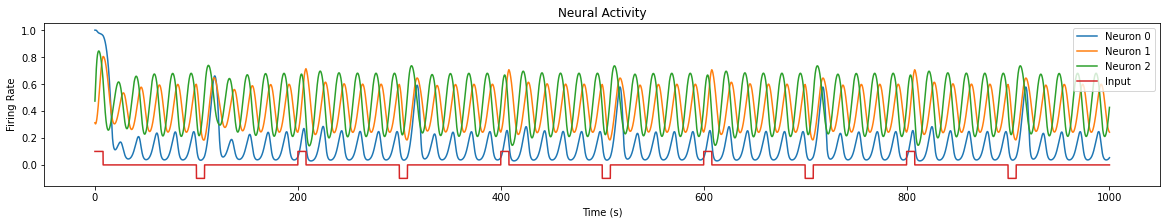

In [5]:
N = CTRNN(3,0.01,1,100000)
N.setWeights(np.array([[5.422,-0.24,0.535],[-0.018,4.59,-2.25],[2.75,1.21,3.885]]))
N.setBiases(np.array([-4.108,-2.787,-1.114]))
N.setTimeConstants(np.ones(3))
N.setInputs(np.zeros(3))
N.initializeState(np.array([20.,2.,1.]))
i = 0
while i in range(100000):
    if i % 20000 == 0:
        N.setInputs(np.ones(3)*.1)
    if (i+10000)%20000 == 0:
        N.setInputs(np.ones(3)*-.1)
    if i % 10000 == 800:
        N.setInputs(np.zeros(3))
#    N.setInputs(np.random.normal(scale=0.5,size=3))
    N.ctrnnstep()
    i+=1
    
N.plot(True)

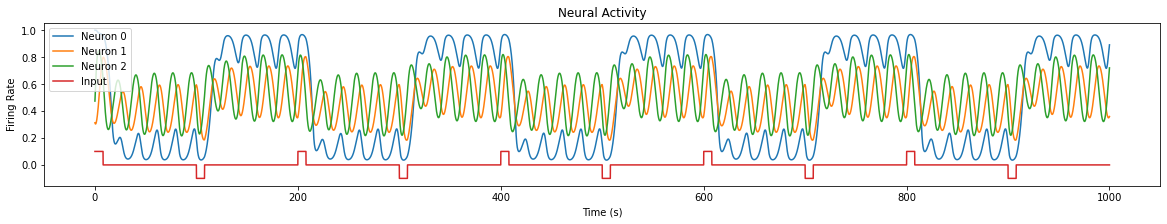

In [54]:
N = CTRNN(3,0.01,1,100000)
N.setWeights(np.array([[5.42,-0.24,0.53],[-0.018,4.59,-2.25],[2.75,1.2,3.88]]))
N.setBiases(np.array([-4.10,-2.787,-1.114]))
N.setTimeConstants(np.ones(3))
N.setInputs(np.zeros(3))
N.initializeState(np.array([20.,2.,1.]))
i = 0
while i in range(100000):
    if i % 20000 == 0:
        N.setInputs(np.ones(3)*.1)
    if (i+10000)%20000 == 0:
        N.setInputs(np.ones(3)*-.1)
    if i % 10000 == 800:
        N.setInputs(np.zeros(3))
#    N.setInputs(np.random.normal(scale=0.5,size=3))
    N.ctrnnstep()
    i+=1
    
N.plot()

In [3]:
##One-legged walker with interneuron

# Constants
LegLength = np.array([15,15])
MaxLegForce = 0.05
ForwardAngleLimit = math.pi/6.0
BackwardAngleLimit = -math.pi/6.0
MaxVelocity = 6.0
MaxTorque = 0.5
MaxOmega = 1.0

class LeggedAgent:

    def __init__(self,l,stepsize):   #l= number of legs, l=1 for me
        self.legs = l
        self.ix = 0.0
        self.iy = 0.0
        self.cx = 0.0
        self.cy = 0.0
        self.vx = 0.0
        self.footstate = np.zeros(l)
        self.angle = np.repeat(np.array(ForwardAngleLimit),l)
        self.omega = np.zeros(l)
        self.forwardForce = np.zeros(l)
        self.backwardForce = np.zeros(l)
        self.jointX = np.repeat(self.cx,l)
        self.jointY = np.repeat(self.cy + 12.5,l)
        self.footX = self.jointX + LegLength * np.sin(self.angle)
        self.footY = self.jointY + LegLength * np.cos(self.angle)
        self.stepsize = stepsize

    def state(self):
        return np.array([self.angle, self.omega, self.footstate])

    def out(self):
        return np.array([self.angle * 5.0/ForwardAngleLimit])

    def walkstep(self, u):
        force = np.zeros(self.legs)
        for i in range(self.legs):
            # Update the leg effectors
            if (u[i] > 0.5):
                self.footstate[i] = 1
                self.omega[i] = 0
                self.forwardForce[i] = 2 * (u[i] - 0.5) * MaxLegForce;
                self.backwardForce[i] = 0.0
            else:
                self.footstate[i] = 0
                self.forwardForce[i] = 0.0
                self.backwardForce[i] = 2 * (0.5 - u[i]) * MaxLegForce;

        # Compute force applied to the body
        for i in range(self.legs):
            f = self.forwardForce[i] - self.backwardForce[i]
            if self.footstate[i] == 1.0:
                if ((self.angle[i] >= BackwardAngleLimit and self.angle[i] <= ForwardAngleLimit) or
                    (self.angle[i] < BackwardAngleLimit and f < 0) or
                    (self.angle[i] > ForwardAngleLimit and f > 0)):
                    force[i] = f
        totalforce = sum(force)

        # Update the position of the body
        self.vx = self.vx + self.stepsize * totalforce
        if (self.vx < -MaxVelocity):
            self.vx = -MaxVelocity
        if (self.vx > MaxVelocity):
            self.vx = MaxVelocity
        self.cx = self.cx + self.stepsize * self.vx
        
        # Update the leg geometry
        for i in range(self.legs):
            self.jointX[i] = self.jointX[i] + self.stepsize * self.vx
            if (self.footstate[i] == 1.0):
                angle = math.atan2(self.footX[i] - self.jointX[i], self.footY[i] - self.jointY[i])
                self.omega[i] = (angle - self.angle[i])/self.stepsize
                self.angle[i] = angle
            else:
                self.vx = 0.0
                self.omega[i] = self.omega[i] + self.stepsize * MaxTorque * (self.backwardForce[i] - self.forwardForce[i])
                if (self.omega[i] < -MaxOmega):
                    self.omega[i] = -MaxOmega
                if (self.omega[i] > MaxOmega):
                    self.omega[i] = MaxOmega
                self.angle[i] = self.angle[i] + self.stepsize * self.omega[i]
                if (self.angle[i] < BackwardAngleLimit):
                    self.angle[i] = BackwardAngleLimit
                    self.omega[i] = 0
                if (self.angle[i] > ForwardAngleLimit):
                    self.angle[i] = ForwardAngleLimit
                    self.omega[i] = 0
                self.footX[i] = self.jointX[i] + LegLength[i] * math.sin(self.angle[i])
                self.footY[i] = self.jointY[i] + LegLength[i] * math.cos(self.angle[i])

        # If any foot is too far back, the body becomes "unstable" and forward motion ceases
        for i in range(self.legs):
            if (self.cx - self.footX[i] > 20):
                self.vx = 0.0
        
    
    def run(self,duration,n):  #duration is in steps, n is an object of class CTRNN
        self.walker_record = np.zeros(duration)
        for t in range(duration): 
            n.ctrnnstep()
            self.walkstep(n.Outputs)
            self.walker_record[t] = self.cx
            

0.2750747447277714


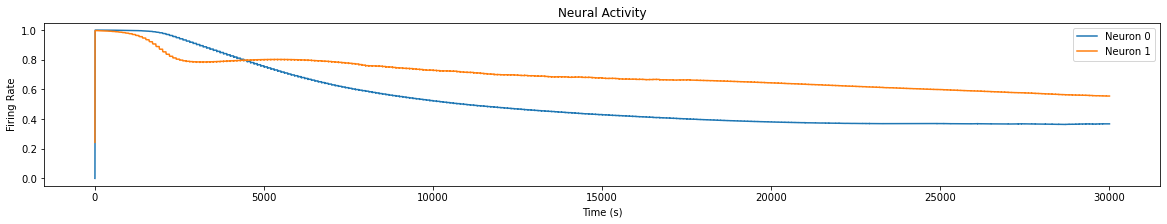

In [62]:
# Parameters for a whole lifetime run of an agent
network_size = 2
dt = .1
segmentlen = 1000
numsegments = 300
neuron_timeconsts = np.array([1,3])



N = CTRNN(network_size,dt,segmentlen,numsegments)
N.randomizeWeights()
N.randomizeBiases()
N.initializeState(np.array([-10.0,-10.0]))
N.setTimeConstants(neuron_timeconsts)
N.setInputs(np.zeros(2))
N.randomizeAdaptiveTimeConstants()
N.setFacilitationFunctionParams(.4,.6,-10)

A = LeggedAgent(1,dt)
k=0
for i in range(numsegments):
    A.run(segmentlen,N)
    avg_speed = (A.walker_record[-1] - A.walker_record[0]) / (segmentlen * dt)
    if avg_speed > k:
        print(avg_speed)
        k=avg_speed
    N.learnstep(avg_speed)
N.plot()


In [7]:
States = np.array([-10.0,-10.0])
Biases = np.array([0.0,0.0])

sigmoid(States+Biases)

array([4.53978687e-05, 4.53978687e-05])

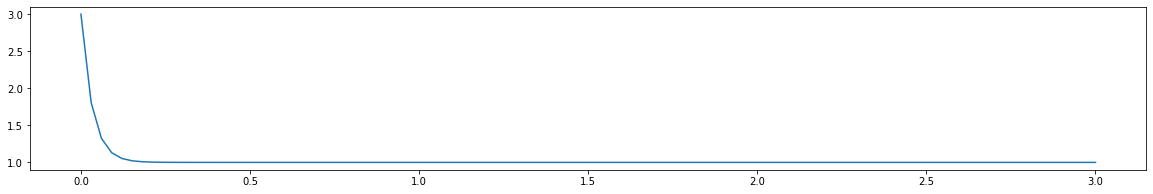

In [60]:
x = np.linspace(0,3,100)
plt.plot(x,2/(sigmoid(30*x))-1)
